# Implementação visualização do triângulo

No caso, está sendo implementado duas versões

1- **Inicial**: a implementação não usa classes como Triangle, Camera, Hittable, etc. 

2- **final**: a implementação usa classes como Triangle, Camera, Hittable, etc.

## Importações

In [1]:
import sys
import os

import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('../../..')))

from Atividade04.src.classes.Ray import Ray
from Atividade02.src.vectorized.Vec3 import Vec3, Point3, Color
from Atividade01.src.ImageIO import ImageWriter
from Atividade01.src.Image import Image

from Atividade04.src.classes.Triangle import Triangle
from Atividade04.src.classes.HittableList import HittableList
from Atividade04.src.classes.Camera import Camera
from Atividade04.src.constants import infinity
from Atividade04.src.classes.Interval import Interval

## Implementação inicial

In [2]:
aspect_ratio = 16.0 / 9.0
image_width = 400

image_height = int(image_width / aspect_ratio)
if image_height < 1:
    image_height = 1

viewport_height = 2.0
viewport_width = viewport_height * (image_width / image_height)
# OBS: viewport_width: não está usando a variável aspect_ratio, pois a variável aspect_ratio é a proporção ideal da imagem, porém, arredondamos image_height para inteiro, podendo assim perder um pouco de precisão na proporção da imagem.


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:14<00:00, 15.21it/s]


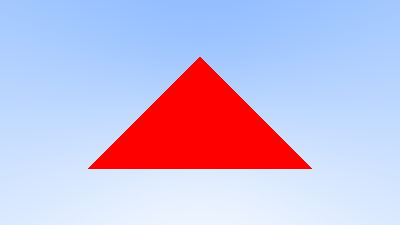

In [3]:
# Baseado no tutorial disponível em:
# https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-rendering-a-triangle/ray-triangle-intersection-geometric-solution.html


def hit_triangle(vertex_1: Point3, vertex_2: Point3, vertex_3: Point3, ray: Ray):

    # Descobrindo o vetor normal
    v1_to_v2 = vertex_2 - vertex_1
    v1_to_v3 = vertex_3 - vertex_1
    normal = v1_to_v2.cross(v1_to_v3)

    # Descobrindo o valor P: intersecção do raio com o plano formado pelo triângulo
    normal_dot_ray_dir = normal.dot(ray.direction)
    if normal_dot_ray_dir == 0:
        return False  # O raio é paralelo ao plano
    
    d = -normal.dot(vertex_1)
    t = -(normal.dot(ray.origin) + d) / normal_dot_ray_dir

    if t < 0:
        return False  # O triângulo está atrás do raio
    
    intersect_point = ray.at(t)

    # Verificando se o ponto de intersecção está dentro ou fora do triângulo
    # Todo lugar que retornar False, quer dizer que o ponto está à direita da aresta, logo, fora do triângulo
    # Só estará dentro do triângulo se para todas as arestas, o ponto estiver para esquerda
    edge_1 = vertex_2 - vertex_1
    vp1= intersect_point - vertex_1
    c = edge_1.cross(vp1)
    if normal.dot(c) < 0:
        return False
    
    edge_2 = vertex_3 - vertex_2
    vp2= intersect_point - vertex_2
    c = edge_2.cross(vp2)
    if normal.dot(c) < 0:
        return False

    edge_3 = vertex_1 - vertex_3
    vp3= intersect_point - vertex_3
    c = edge_3.cross(vp3)
    if normal.dot(c) < 0:
        return False
    
    return True


def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    if hit_triangle(Point3([-1, -0.5, -1]), Point3([0.0, 0.5, -1]), Point3([1.0, -0.5, -1]), ray):
        return Color([1, 0, 0])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

    
raytrace_pipeline('../../imgs/initial-triangle.png')

## Implementação final

In [4]:
def ray_color(ray: Ray, world: HittableList) -> Color:
    hit, rec = world.hit(ray, Interval(0, infinity))
    if hit:
        return Color([1, 0, 0])
    
    unit_direction = ray.direction.unit_vector()
    t = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - t) * Color([1.0, 1.0, 1.0]) + t * Color([0.5, 0.7, 1.0])

100%|██████████| 225/225 [00:15<00:00, 14.50it/s]


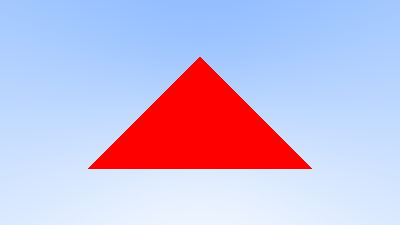

In [5]:
camera = Camera()

world = HittableList()
world.add(Triangle(Point3([-1, -0.5, -1]), Point3([0.0, 0.5, -1]), Point3([1.0, -0.5, -1])))

camera.ray_color = ray_color  # Para manter o mesmo desenho, é trocado a função ray_color
# A que está implementada originalmente na classe utiliza a normal para dar cor

camera.render(world, '../../imgs/final-triangle.png')